In [1]:
# Importing necessary libraries for PyTorch and data visualization
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision import datasets, transforms

# Setting a random seed for reproducibility
random_seed = 1
torch.backends.cudnn.enabled = False  # Disabling CuDNN for deterministic results
_ = torch.manual_seed(random_seed)  # Setting manual seed for random number generation

# Preparing the Dataset

In [2]:
# Defining batch sizes for training and testing data
batch_size_train = 64
batch_size_test = 1000

# Defining data transformations, including converting images to tensors and normalizing pixel values
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]
)

# Loading MNIST dataset for training and testing
# For training data, setting train=True, downloading if not available, and applying transformations
dataset1 = datasets.MNIST("../data", train=True, download=True, transform=transform)

# For testing data, setting train=False, not downloading, and applying transformations
dataset2 = datasets.MNIST("../data", train=False, transform=transform)

# Creating data loaders for efficient batch processing during training and testing
# For training data, using DataLoader with specified batch size and shuffling the data
train_loader = torch.utils.data.DataLoader(
    dataset1, batch_size=batch_size_train, shuffle=True
)

# For testing data, using DataLoader with specified batch size and shuffling the data
test_loader = torch.utils.data.DataLoader(
    dataset2, batch_size=batch_size_test, shuffle=True
)

Shape of example_data: torch.Size([1000, 1, 28, 28])


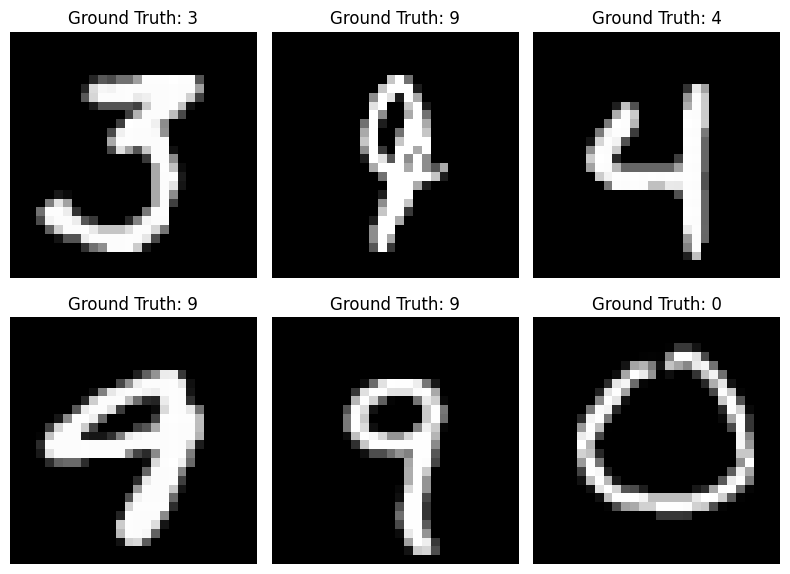

In [3]:
# Getting one batch of examples from the test_loader
batch_idx, (example_data, example_targets) = next(enumerate(test_loader))

# Printing the shape of the example_data tensor
print("Shape of example_data:", example_data.shape)

# Plotting the first 6 images along with their labels
fig, axes = plt.subplots(2, 3, figsize=(8, 6))

for i, ax in enumerate(axes.flat):
    ax.imshow(example_data[i][0], cmap="gray", interpolation="none")
    ax.set_title("Ground Truth: {}".format(example_targets[i]))
    ax.axis('off')

plt.tight_layout()
plt.show()

# Building the Network

In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        # Define convolutional layers
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout2d(0.25)
        )
        
        # Define fully connected layers
        self.fc_layers = nn.Sequential(
            nn.Linear(9216, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 10)
        )
        
        # Initialize weights
        self._initialize_weights()

    def forward(self, x):
        x = self.conv_layers(x)
        x = torch.flatten(x, 1)
        x = self.fc_layers(x)
        output = F.log_softmax(x, dim=1)
        return output
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    init.constant_(m.bias, 0)

In [5]:
learning_rate = 1
model = Net()
optimizer = optim.Adadelta(model.parameters(), lr=learning_rate)

In [6]:
n_epochs = 3
train_losses = []
train_counter = []
test_losses = []
test_counter = [i * len(test_loader.dataset) for i in range(n_epochs + 1)]

# Training the Model

In [7]:
log_interval = 50


def train(epoch):
    """
    Training function for the neural network model.

    Args:
        epoch (int): Current epoch number.
    """
    model.train()  # Set the model to training mode
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()  # Zero the gradients
        output = model(data)  # Forward pass
        loss = F.nll_loss(output, target)  # Calculate the loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights

        # Print training progress and store losses
        if batch_idx % log_interval == 0:
            print(
                "Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                    epoch,
                    batch_idx * len(data),
                    len(train_loader.dataset),
                    100.0 * batch_idx / len(train_loader),
                    loss.item(),
                )
            )
            train_losses.append(loss.item())
            train_counter.append(
                (batch_idx * len(data)) + ((epoch - 1) * len(train_loader.dataset))
            )
    # Save model and optimizer states at the end of each epoch
    torch.save(model.state_dict(), '../results/model_epoch_{}.pth'.format(epoch))
    torch.save(optimizer.state_dict(), '../results/optimizer_epoch_{}.pth'.format(epoch))

def test():
    """
    Evaluation function for the neural network model on the test set.
    """
    model.eval()  # Set the model to evaluation mode
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)  # Forward pass
            test_loss += F.nll_loss(
                output, target, reduction="sum"
            ).item()  # Calculate the loss
            pred = output.argmax(dim=1, keepdim=True)  # Get the predicted labels
            correct += (
                pred.eq(target.view_as(pred)).sum().item()
            )  # Count correct predictions

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)  # Store test loss

    # Print test set results
    print(
        "\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n".format(
            test_loss,
            correct,
            len(test_loader.dataset),
            100.0 * correct / len(test_loader.dataset),
        )
    )

In [8]:
# Training and testing loop
for epoch in range(1, n_epochs + 1):
    train(epoch)  # Train the model for the current epoch
    test()  # Evaluate the model on the test set after training


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.343237
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.393390
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.307750
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.172326
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.207499
Train Epoch: 1 [16000/60000 (27%)]	Loss: 0.236228
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.193880
Train Epoch: 1 [22400/60000 (37%)]	Loss: 0.142028
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.057478
Train Epoch: 1 [28800/60000 (48%)]	Loss: 0.254511
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.169719
Train Epoch: 1 [35200/60000 (59%)]	Loss: 0.123499
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.124683
Train Epoch: 1 [41600/60000 (69%)]	Loss: 0.087026
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.026426
Train Epoch: 1 [48000/60000 (80%)]	Loss: 0.193358
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.167916
Train Epoch: 1 [54400/60000 (91%)]	Loss: 0.012772
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.047485

Test set: Average loss: 0.0546, Accuracy: 9832/10000 (98%)

# Evaluating the Model's Performance

In [15]:
test_counter = [i * len(train_loader.dataset) for i in range(n_epochs)]

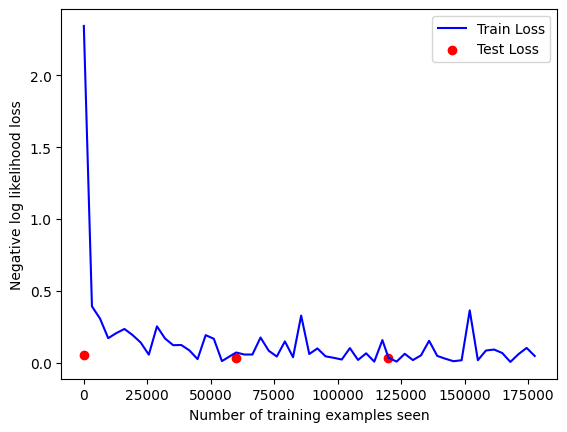

In [16]:
# Create a new figure for plotting
fig = plt.figure()

# Plot training losses as a blue line
plt.plot(train_counter, train_losses, color="blue")

# Scatter plot of test losses as red points
plt.scatter(test_counter, test_losses, color="red")

# Add legend and labels
plt.legend(["Train Loss", "Test Loss"], loc="upper right")
plt.xlabel("Number of training examples seen")
plt.ylabel("Negative log likelihood loss")

# Display the plot
plt.show()

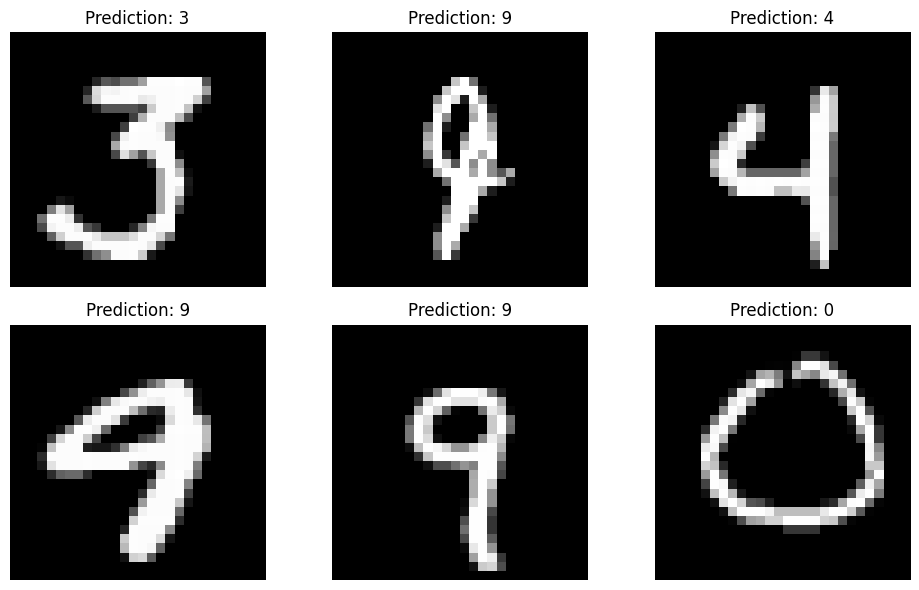

In [17]:
with torch.no_grad():
    # Disable gradient calculation
    output = model(example_data)  # Forward pass of the model with example_data
    fig, axes = plt.subplots(2, 3, figsize=(10, 6))  # Create a 2x3 grid of subplots
    predictions = output.data.max(1, keepdim=True)[1]  # Calculate predictions once
    # Iterate over each subplot
    for i, ax in enumerate(axes.flat):
        ax.imshow(example_data[i][0], cmap="gray", interpolation="none")
        ax.set_title("Prediction: {}".format(predictions[i].item()))
        ax.axis('off')  # Hide axis labels

    plt.tight_layout()  # Adjust layout
    plt.show()